In [1]:
import pandas as pd
import numpy as np
import random
import os

SEED = 42
def seed_everything(seed: int = SEED):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything()

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import catboost
from catboost import CatBoostClassifier, CatBoostRegressor

from sklearn.metrics import f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train_preprocessed_3.csv')
test = pd.read_csv('test_preprocessed_3.csv')

In [3]:
def encode_categorical_variables(train, test):
    categorical_columns = train.select_dtypes(include=['object']).columns.tolist()
    
    label_encoders = {}
    
    for col in categorical_columns:
        le = LabelEncoder()
        le = le.fit(train[col])
        train[col] = le.transform(train[col])
        
        for label in np.unique(test[col]):
            if label not in le.classes_:
                le.classes_ = np.append(le.classes_, label)
        test[col] = le.transform(test[col])
    
    return train, test

train, test = encode_categorical_variables(train, test)

In [4]:
def encode_with_other_category(train, test, column_name):
    le = LabelEncoder()
    train[column_name] = train[column_name].astype(str)  # int를 str로 변환
    le.fit(train[column_name])
    
    # 테스트 데이터에 대해 'other' 카테고리 처리
    # train에 없는 라벨을 기준으로 한다.
    test[column_name] = test[column_name].astype(str)  # int를 str로 변환
    test[column_name] = test[column_name].apply(lambda x: x if x in le.classes_ else 'other')
    
    # 'other' 라벨 추가
    le_classes = np.append(le.classes_, 'other')
    le.classes_ = le_classes
    
    # 라벨 인코딩 적용
    train[column_name] = le.transform(train[column_name])
    test[column_name] = le.transform(test[column_name])
    
    return train, test

train, test = encode_with_other_category(train, test, "customer_idx")
train, test = encode_with_other_category(train, test, "lead_owner")

In [6]:
train.shape, test.shape

((59299, 84), (5271, 84))

In [8]:
def drop_columns_and_return(train, test, cols):
    # cols 매개변수를 사용하여 여러 열을 한 번에 삭제할 수 있도록 수정
    train = train.drop(cols, axis=1)
    test = test.drop(cols, axis=1)
    return train, test

cols= ['customer_idx_converted_rate','customer_idx','business_unit','customer_position_converted_rate','customer_continent_converted_rate']

train, test= drop_columns_and_return(train, test, cols)

In [9]:
train.shape, test.shape

((59299, 79), (5271, 79))

In [10]:
train_y = train['is_converted']
train_X = train.drop(columns='is_converted', axis=1)

train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, train_size=0.8, shuffle=True, stratify=train_y)
test = test.drop(columns='is_converted', axis=1)

# Voting

In [11]:
lgbm = LGBMClassifier(
        nthread=4,
        n_estimators=1000,
        learning_rate=0.02,
        max_depth=10,
        num_leaves=60,
        colsample_bytree=0.511,
        subsample=0.785,
        max_bin=208,
        reg_alpha=7.009,
        reg_lambda=6.579,
        min_child_weight=40,
        min_child_samples=91,
        silent=-1,
        verbose=-1,
        random_state=SEED)

cbc = CatBoostClassifier(
        iterations=10670, 
        od_wait=1507, 
        learning_rate=0.16098437506461638, 
        reg_lambda=24.546834859312227, 
        subsample=0.16549759534249936, 
        random_strength=49.80933051421884, 
        depth=6, 
        min_data_in_leaf=14, 
        leaf_estimation_iterations=14, 
        bagging_temperature=0.39841620949747386, 
        colsample_bylevel=0.6140733146459497,
        verbose=100, 
        task_type='CPU',
        random_state=SEED)

xgb = XGBClassifier(
        colsample_bytree=0.8497054793943353, 
        gamma=3.935081236491979, 
        learning_rate=0.07509368737832518, 
        max_depth=int(7.215329530514387),  
        min_child_weight=int(1.7019371790152105),  
        n_estimators=int(240.30115793246688),  
        subsample=0.971358258121751,
        random_state=SEED)

rf = RandomForestClassifier(
        max_depth=int(77.32983850657278),  
        min_samples_leaf=int(2.9945638773827494),
        min_samples_split=int(3.126668709295796),  
        n_estimators=int(224.4759742656425),
        random_state=SEED)

# lr = LogisticRegression(
#         C=0.41994536370093083, 
#         penalty='l2', 
#         l1_ratio=0.7209270556562788,
#         max_iter=1000,
#         solver='saga',
#         random_state=SEED)

bagging = BaggingClassifier(random_state=SEED)

models = [lgbm, cbc, xgb, rf, bagging]

In [12]:
# weight 찾기
model_list = ['lgbm', 'cbc', 'xgb', 'rf', 'bagging']
i = 0; model_f1 = {}
best_threshold= 0.0035

for model in models:  
    model.fit(train_X, train_y)
    pred = model.predict(valid_X)
    if model_list[i] == 'cbc':
        pred = np.array(pred) == 'True'
    globals()[f'preds_{model_list[i]}'] = pred

    score = f1_score(valid_y, pred)
    model_f1[model_list[i]] = score
    i += 1   

0:	learn: 0.5471702	total: 62.6ms	remaining: 11m 8s
100:	learn: 0.1118858	total: 704ms	remaining: 1m 13s
200:	learn: 0.0928219	total: 1.28s	remaining: 1m 6s
300:	learn: 0.0858357	total: 1.87s	remaining: 1m 4s
400:	learn: 0.0784114	total: 2.45s	remaining: 1m 2s
500:	learn: 0.0733881	total: 3.03s	remaining: 1m 1s
600:	learn: 0.0686364	total: 3.61s	remaining: 1m
700:	learn: 0.0644628	total: 4.2s	remaining: 59.7s
800:	learn: 0.0608355	total: 4.78s	remaining: 58.9s
900:	learn: 0.0577216	total: 5.36s	remaining: 58.1s
1000:	learn: 0.0543468	total: 5.94s	remaining: 57.4s
1100:	learn: 0.0515484	total: 6.52s	remaining: 56.7s
1200:	learn: 0.0488964	total: 7.11s	remaining: 56s
1300:	learn: 0.0470957	total: 7.68s	remaining: 55.3s
1400:	learn: 0.0449272	total: 8.27s	remaining: 54.7s
1500:	learn: 0.0430590	total: 8.85s	remaining: 54.1s
1600:	learn: 0.0412385	total: 9.43s	remaining: 53.4s
1700:	learn: 0.0397602	total: 10s	remaining: 52.8s
1800:	learn: 0.0385847	total: 10.6s	remaining: 52.1s
1900:	lear

In [14]:
print(globals()['preds_lgbm'])
print(model_f1)   # {'lgbm': 0.9773429454170957, 'cbc': 0.9804727646454265, 'xgb': 0.9820788530465949, 'rf': 0.9798657718120805, 'bagging': 0.9783281733746131}

[False False  True ... False False False]
{'lgbm': 0.6903262736119061, 'cbc': 0.7648327939590076, 'xgb': 0.7054131054131054, 'rf': 0.7043949428055388, 'bagging': 0.7297146054840515}


In [15]:
estimators = [('lgbm', lgbm), ('cbc', cbc), ('xgb', xgb), ('rf', rf), ('bagging', bagging)]
best_model = VotingClassifier(estimators, voting='soft', weights=[1, 2, 2, 1, 1]) # hard voting은 predict_proba 안 됨
best_model.fit(train_X, train_y)

0:	learn: 0.5471702	total: 6.66ms	remaining: 1m 11s
100:	learn: 0.1118858	total: 585ms	remaining: 1m 1s
200:	learn: 0.0928219	total: 1.17s	remaining: 1m
300:	learn: 0.0858357	total: 1.75s	remaining: 1m
400:	learn: 0.0784114	total: 2.33s	remaining: 59.6s
500:	learn: 0.0733881	total: 2.9s	remaining: 59s
600:	learn: 0.0686364	total: 3.49s	remaining: 58.4s
700:	learn: 0.0644628	total: 4.08s	remaining: 58s
800:	learn: 0.0608355	total: 4.67s	remaining: 57.5s
900:	learn: 0.0577216	total: 5.24s	remaining: 56.8s
1000:	learn: 0.0543468	total: 5.83s	remaining: 56.3s
1100:	learn: 0.0515484	total: 6.41s	remaining: 55.7s
1200:	learn: 0.0488964	total: 6.99s	remaining: 55.1s
1300:	learn: 0.0470957	total: 7.56s	remaining: 54.5s
1400:	learn: 0.0449272	total: 8.14s	remaining: 53.9s
1500:	learn: 0.0430590	total: 8.72s	remaining: 53.3s
1600:	learn: 0.0412385	total: 9.3s	remaining: 52.7s
1700:	learn: 0.0397602	total: 9.87s	remaining: 52.1s
1800:	learn: 0.0385847	total: 10.4s	remaining: 51.4s
1900:	learn: 0.

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(colsample_bytree=0.511,
                                             learning_rate=0.02, max_bin=208,
                                             max_depth=10, min_child_samples=91,
                                             min_child_weight=40,
                                             n_estimators=1000, nthread=4,
                                             num_leaves=60, random_state=42,
                                             reg_alpha=7.009, reg_lambda=6.579,
                                             silent=-1, subsample=0.785,
                                             verbose=-1)),
                             ('cbc',
                              <catboost.core.CatBoostClassifier object at 0x7efff1d42d...
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=240, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('rf',
                              RandomForestClassifier(max_depth=77,
                                                     min_samples_leaf=2,
                                                     min_samples_split=3,
                                                     n_estimators=224,
                                                     random_state=42)),
                             ('bagging', BaggingClassifier(random_state=42))],
                 voting='soft', weights=[1, 2, 2, 1, 1])

In [16]:
pred = best_model.predict(valid_X)
score = f1_score(pred, valid_y) 
print(score) # 검증 스코어

0.749298934380258


In [17]:
pred = best_model.predict(test)                       #test 예측 비율 확인
ones_ratio = sum(pred) / len(pred);ones_ratio 

0.13564788465186872

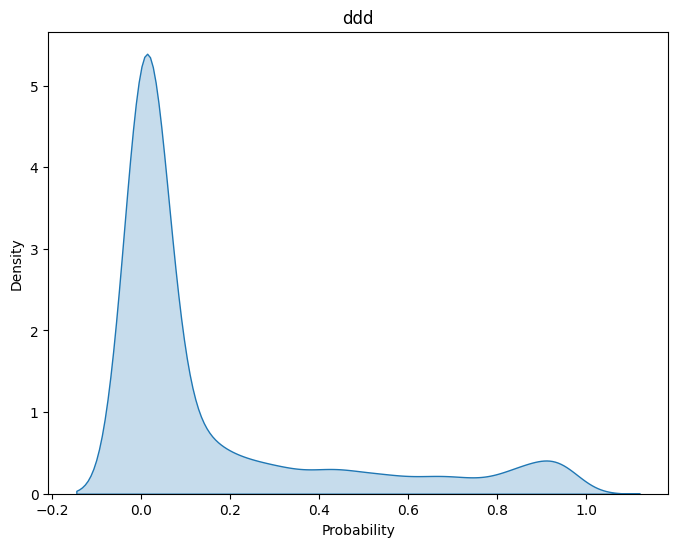

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
pred_probs = best_model.predict_proba(test)[:, 1]
plt.figure(figsize=(8, 6))
sns.kdeplot(pred_probs, shade=True)
plt.title('ddd')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.show()

In [29]:
# 제출용 prediction
best_threshold = 0.07
pred_probs = best_model.predict_proba(test)[:, 1]
final_preds = pred_probs >= best_threshold
print(sum(final_preds) / len(final_preds)) # True 비율

0.33181559476380196


In [30]:
# True, False로 수정
def convert_to_boolean_vector(input_vector):
    return np.array(input_vector == 1, dtype=bool)          
    
result_vector = convert_to_boolean_vector(final_preds)

In [31]:
submission = pd.read_csv('submission.csv')
submission['is_converted'] = result_vector
submission.to_csv('submission.csv')